
# 02 — Data Cleaning & Integration

This notebook loads the three raw CSVs, harmonizes schemas, cleans + engineers key features,
computes a **Data Quality Report**, creates a lightweight **profiling snapshot**, and exports a single
**cleaned master dataset**.



## 1) Imports & Paths

Before manipulating data, we must set up the environment — define where data lives and where cleaned outputs will go. Think of this like laying out your lab tools before starting an experiment. Without consistent paths, reproducibility collapses.


In [1]:

import pandas as pd
import numpy as np
from pathlib import Path
import json
from datetime import datetime

# Charting (matplotlib only, no seaborn per your tool constraints)
import matplotlib.pyplot as plt

# Paths
REPO_ROOT = Path(".").resolve()

RAW_DIR_REPO   = REPO_ROOT / "data" / "raw"
PROC_DIR_REPO  = REPO_ROOT / "data" / "processed"
REPORTS_REPO   = PROC_DIR_REPO / "reports"

# Fallback for this environment (uploaded files live in /mnt/data)
RAW_DIR_FALLBACK = Path("/mnt/data")

# Decide which raw directory to use
if RAW_DIR_REPO.exists():
    RAW = RAW_DIR_REPO
else:
    RAW = RAW_DIR_FALLBACK

# Ensure processed/report directories exist (in-repo if possible else /mnt/data/processed)
if PROC_DIR_REPO.parent.exists():
    PROCESSED = PROC_DIR_REPO
    REPORTS   = REPORTS_REPO
else:
    PROCESSED = Path("/mnt/data/processed")
    REPORTS   = PROCESSED / "reports"

PROCESSED.mkdir(parents=True, exist_ok=True)
REPORTS.mkdir(parents=True, exist_ok=True)

RAW, PROCESSED, REPORTS


(WindowsPath('/mnt/data'),
 WindowsPath('/mnt/data/processed'),
 WindowsPath('/mnt/data/processed/reports'))


## 2) Discover Raw Files


We look for the four expected CSVs by **exact filename** first. If not present, we try pattern matches.


In [2]:
# ================================================
# Load Raw Datasets (Relative Path + GitHub Safe)
# ================================================
from pathlib import Path
import pandas as pd

# --- Step 1: Find project root and navigate to data/raw ---
# Start from current file location and go up to project root
current_dir = Path.cwd()

# Check if we're in notebooks/ folder, if so go up one level
if current_dir.name == "notebooks":
    project_root = current_dir.parent
else:
    project_root = current_dir

DATA_RAW = project_root / "data" / "raw"

print("📂 Using raw data folder:", DATA_RAW.resolve())

# Verify the path exists
if not DATA_RAW.exists():
    raise FileNotFoundError(f"❌ Directory not found: {DATA_RAW}\nCurrent working directory: {Path.cwd()}")

# --- Step 2: List all CSVs found ---
csv_files = list(DATA_RAW.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {DATA_RAW.resolve()}. Please check your data folder.")

print(f"✅ Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(" -", f.name)

# --- Step 3: Load the four datasets explicitly ---
df1 = pd.read_csv(DATA_RAW / "dataset1_data_science_job.csv")
df2 = pd.read_csv(DATA_RAW / "dataset2_all_job_post.csv")
df3 = pd.read_csv(DATA_RAW / "dataset3_ai_job_dataset.csv")
df4 = pd.read_csv(DATA_RAW / "dataset3_ai_job_dataset1.csv")

# --- Step 4: Quick verification ---
for name, df in {"df1": df1, "df2": df2, "df3": df3, "df4": df4}.items():
    print(f"\n{name}: shape={df.shape}")
    display(df.head(2))
    display(df.info())

# --- Step 5: Merge all datasets into one master ---
master = pd.concat([df1, df2, df3, df4], ignore_index=True)
master.drop_duplicates(inplace=True)
print("\n✅ Merged master shape:", master.shape)

# --- Optional: Save to processed folder ---
PROCESSED_DIR = project_root / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
master.to_csv(PROCESSED_DIR / "cleaned_master.csv", index=False)
print(f"💾 Saved to: {PROCESSED_DIR / 'cleaned_master.csv'}")

📂 Using raw data folder: C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\data\raw
✅ Found 4 CSV files:
 - dataset1_data_science_job.csv
 - dataset2_all_job_post.csv
 - dataset3_ai_job_dataset.csv
 - dataset3_ai_job_dataset1.csv

df1: shape=(5000, 12)


,work_year,job_title,job_category,salary_currency,salary,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,2022,Machine Learning Engineer in office,Analysis,EUR,186597,136086,US,MI,CT,Remote,DE,L
1,2020,Statistician (Remote),ML/AI,JPY,110630,67982,JP,EX,FL,Remote,IN,M


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           5000 non-null   int64 
 1   job_title           5000 non-null   object
 2   job_category        4500 non-null   object
 3   salary_currency     4500 non-null   object
 4   salary              5000 non-null   int64 
 5   salary_in_usd       5000 non-null   int64 
 6   employee_residence  5000 non-null   object
 7   experience_level    4500 non-null   object
 8   employment_type     5000 non-null   object
 9   work_setting        5000 non-null   object
 10  company_location    5000 non-null   object
 11  company_size        4500 non-null   object
dtypes: int64(3), object(9)
memory usage: 468.9+ KB


None


df2: shape=(1167, 5)


,job_id,category,job_title,job_description,job_skill_set
0,3902668440,HR,Sr Human Resource Generalist,SUMMARY\nTHE SR. HR GENERALIST PROVIDES HR EXP...,"['employee relations', 'talent acquisition', '..."
1,3905823748,HR,Human Resources Manager,BE PART OF A STELLAR TEAM AT YSB AS THE MANAGE...,"['Talent Acquisition', 'Employee Performance M..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_id           1167 non-null   int64 
 1   category         1167 non-null   object
 2   job_title        1167 non-null   object
 3   job_description  1167 non-null   object
 4   job_skill_set    1167 non-null   object
dtypes: int64(1), object(4)
memory usage: 45.7+ KB


None


df3: shape=(15000, 19)


,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry                15000 non-null  object 
 14  posting_date            15000 non-null

None


df4: shape=(15000, 20)


,job_id,job_title,salary_usd,salary_currency,salary_local,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,Data Scientist,219728,USD,219728,EX,PT,Sweden,M,Sweden,0,"Python, Computer Vision, R, Docker",Associate,13,Transportation,2024-09-23,2024-10-31,1132,6.6,TechCorp Inc
1,AI00002,Head of AI,230237,JPY,25326070,EX,PT,Japan,L,Japan,50,"Kubernetes, MLOps, Tableau, Python",Bachelor,10,Transportation,2024-07-26,2024-09-12,2299,8.5,Cloud AI Solutions


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   salary_local            15000 non-null  int64  
 5   experience_level        15000 non-null  object 
 6   employment_type         15000 non-null  object 
 7   company_location        15000 non-null  object 
 8   company_size            15000 non-null  object 
 9   employee_residence      15000 non-null  object 
 10  remote_ratio            15000 non-null  int64  
 11  required_skills         15000 non-null  object 
 12  education_required      15000 non-null  object 
 13  years_experience        15000 non-null  int64  
 14  industry                15000 non-null

None


✅ Merged master shape: (36167, 28)
💾 Saved to: c:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\data\processed\cleaned_master.csv



## 3) Load CSVs

We load available files and warn on any missing ones (the notebook still runs with the available data).


In [3]:
# ================================================
# Robust CSV Loader - GitHub Safe & Works Anywhere
# ================================================
from pathlib import Path
import json
import pandas as pd

# 1) Smart project root detection
def find_project_root():
    """Find project root by looking for 'data' folder"""
    current = Path.cwd()
    
    # Check current directory and parents
    for parent in [current] + list(current.parents):
        if (parent / "data" / "raw").exists():
            return parent
    
    # If not found, return current directory
    return current

# Set project root and candidate directories
PROJECT_ROOT = find_project_root()
CANDIDATE_DIRS = [
    PROJECT_ROOT / "data" / "raw",      # main location
    PROJECT_ROOT / "data",               # fallback
    Path("./data/raw"),                  # relative path
    Path("./data"),                      # relative fallback
    Path.cwd(),                          # current directory
]

print(f"🎯 Project root detected: {PROJECT_ROOT.name}/")

# 2) The filenames we expect
FILENAMES = {
    "dataset1": "dataset1_data_science_job.csv",
    "dataset2": "dataset2_all_job_post.csv",
    "dataset3": "dataset3_ai_job_dataset.csv",
    "dataset3_v2": "dataset3_ai_job_dataset1.csv",
}

def find_file_anywhere(fname: str):
    """Search for a file in candidate directories"""
    # Check if it's an absolute path
    p = Path(fname)
    if p.exists():
        return p
    
    # Search in candidate directories
    for root in CANDIDATE_DIRS:
        if not root.exists():
            continue
            
        # Direct check
        direct = root / fname
        if direct.exists():
            return direct
        
        # Recursive search (in case file is nested)
        try:
            hits = list(root.rglob(fname))
            if hits:
                return hits[0]
        except (PermissionError, OSError):
            continue
    
    return None

# 3) Resolve all files
resolved = {}
for key, fname in FILENAMES.items():
    p = find_file_anywhere(fname)
    resolved[key] = p

# 4) Load datasets
dfs, load_errors = [], {}

for key, path in resolved.items():
    if path is None:
        fname = FILENAMES[key]
        load_errors[fname] = "File not found"
        continue
    
    try:
        df = pd.read_csv(
            path,
            encoding="utf-8",
            on_bad_lines="skip",
            low_memory=False,
        )
        
        # Parse date columns if they exist
        date_cols = {"posting_date", "application_deadline", "date", "posted_date"}
        existing_date_cols = date_cols & set(df.columns)
        
        for col in existing_date_cols:
            df[col] = pd.to_datetime(df[col], errors="coerce")
        
        # Add source tracking
        df["__source__"] = key
        dfs.append(df)
        
        print(f"✅ Loaded {key}: {df.shape} from {path.name}")
        
    except Exception as e:
        load_errors[str(path.name)] = str(e)

# 5) Report results
print("\n" + "="*60)
print("LOADING SUMMARY")
print("="*60)

print(f"\n🔎 Searched in {len(CANDIDATE_DIRS)} locations:")
for r in CANDIDATE_DIRS:
    exists = "✓" if r.exists() else "✗"
    print(f"  {exists} {r}")

if load_errors:
    print("\n⚠️  Load warnings:")
    for file, error in load_errors.items():
        print(f"  • {file}: {error}")

if not dfs:
    # Debug: show what files ARE in data/raw
    data_raw = PROJECT_ROOT / "data" / "raw"
    if data_raw.exists():
        print(f"\n📁 Files found in {data_raw}:")
        for p in data_raw.glob("*"):
            print(f"  - {p.name}")
    
    raise FileNotFoundError(
        f"❌ No CSV files could be loaded.\n"
        f"Expected location: {PROJECT_ROOT / 'data' / 'raw'}\n"
        f"Make sure your CSV files are in the correct folder!"
    )

print(f"\n✅ Successfully loaded {len(dfs)} dataset(s):")
for i, df in enumerate(dfs, 1):
    src = df["__source__"].iloc[0] if len(df) else "(empty)"
    print(f"  {i}. {src}: shape={df.shape}")

# 6) Combine into master dataset
print("\n" + "="*60)
print("CREATING MASTER DATASET")
print("="*60)

master = pd.concat(dfs, ignore_index=True)
print(f"Combined shape (before dedup): {master.shape}")

# Remove duplicates
master.drop_duplicates(inplace=True)
print(f"Final shape (after dedup): {master.shape}")

# Show source breakdown
print("\n📊 Records per source:")
print(master["__source__"].value_counts().to_string())

# 7) Save to processed folder
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

output_file = PROCESSED_DIR / "cleaned_master.csv"
master.to_csv(output_file, index=False)
print(f"\n💾 Saved to: {output_file.relative_to(PROJECT_ROOT)}")

print("\n✅ All done! Master dataset ready.")

🎯 Project root detected: datathon-2025/
✅ Loaded dataset1: (5000, 13) from dataset1_data_science_job.csv
✅ Loaded dataset2: (1167, 6) from dataset2_all_job_post.csv
✅ Loaded dataset3: (15000, 20) from dataset3_ai_job_dataset.csv
✅ Loaded dataset3_v2: (15000, 21) from dataset3_ai_job_dataset1.csv

LOADING SUMMARY

🔎 Searched in 5 locations:
  ✓ c:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\data\raw
  ✓ c:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\data
  ✗ data\raw
  ✗ data
  ✓ c:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\notebooks

✅ Successfully loaded 4 dataset(s):
  1. dataset1: shape=(5000, 13)
  2. dataset2: shape=(1167, 6)
  3. dataset3: shape=(15000, 20)
  4. dataset3_v2: shape=(15000, 21)

CREATING MASTER DATASET
Combined shape (before dedup): (36167, 29)
Final shape (after dedup): (36167, 29)

📊 Records per source:
__source__
dataset3_v2    15000
dataset3       15000
dataset1        5000
dataset2        1167

💾 Saved to: data\processed\cleaned


## 4) Schema Harmonization

Datasets from different sources often call the same thing by different names — e.g., job_title vs title.
Before merging, we need a shared vocabulary.
This is the lingua franca of your data — making sure everyone (and every dataset) “speaks the same language”.


In [4]:

canonical_cols = [
    "job_title","job_category","salary_currency","salary_min","salary_max","salary_usd",
    "employee_residence","experience_level","employment_type","company_size","company_location",
    "remote_ratio","posting_date","required_skills","years_experience","industry","application_deadline",
    "job_description","company_name"
]

def ensure_columns(df: pd.DataFrame, cols):
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    return df

dfs = [ensure_columns(d, canonical_cols) for d in dfs]

# Minimal dtype fixes
for d in dfs:
    # dates
    for c in ["posting_date", "application_deadline"]:
        if c in d.columns:
            d[c] = pd.to_datetime(d[c], errors="coerce")
    # numerics
    for c in ["salary_min","salary_max","salary_usd","years_experience","remote_ratio"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

print("✅ Canonicalization complete.")


✅ Canonicalization complete.



## 5) Merge to Master

We concatenate all sources and drop exact duplicate rows.


In [5]:

master = pd.concat(dfs, ignore_index=True, sort=False)
before = len(master)
master.drop_duplicates(inplace=True)
after = len(master)

print(f"✅ Merged master shape: {master.shape} (dropped {before-after} duplicates)")


✅ Merged master shape: (36167, 31) (dropped 0 duplicates)



## 6) Core Cleaning

- Drop rows **missing essential keys** (`job_title`).
- Normalize text in key categorical fields.
- Standardize currencies and basic ranges where possible.


In [6]:

# 6.1 Drop rows without job_title (essential for analysis)
if "job_title" in master.columns:
    missing_titles = master["job_title"].isna().sum()
    master = master.dropna(subset=["job_title"])
    print(f"🧹 Dropped {missing_titles} rows with missing job_title.")

# 6.2 Basic text normalization
def norm_text(s):
    if pd.isna(s): return s
    s = str(s).strip()
    return s

text_cols = ["job_title","job_category","employee_residence","experience_level","employment_type",
             "company_size","company_location","required_skills","industry","job_description","company_name"]

for c in text_cols:
    if c in master.columns:
        master[c] = master[c].apply(norm_text)

# 6.3 Currency sanity (no conversion here—just placeholder; conversion happens in FE if needed)
# Ensure salary_min <= salary_max where both present
mask = master["salary_min"].notna() & master["salary_max"].notna() & (master["salary_min"] > master["salary_max"])
if mask.any():
    swapped = mask.sum()
    # swap where min > max
    smin = master.loc[mask, "salary_min"].copy()
    master.loc[mask, "salary_min"] = master.loc[mask, "salary_max"].values
    master.loc[mask, "salary_max"] = smin.values
    print(f"🔀 Swapped salary_min/max in {swapped} rows.")


🧹 Dropped 0 rows with missing job_title.



## 7) Feature Engineering

- `salary_midpoint = (salary_min + salary_max)/2` (fallback to `salary_usd` if only that exists)  
- `skill_count` from `required_skills`  
- Date parts: `posting_year`, `posting_month`, `posting_quarter`


In [7]:

# 7.1 salary_midpoint
if "salary_min" in master.columns and "salary_max" in master.columns:
    master["salary_midpoint"] = (master["salary_min"] + master["salary_max"]) / 2.0

# Fallback: if midpoint missing but salary_usd present, use that as proxy (document decision)
if "salary_midpoint" not in master.columns or master["salary_midpoint"].isna().all():
    if "salary_usd" in master.columns:
        master["salary_midpoint"] = master["salary_usd"]
        print("ℹ️ Using salary_usd as proxy for salary_midpoint (no min/max available).")

# 7.2 skill_count
if "required_skills" in master.columns:
    def count_skills(x):
        if pd.isna(x): return 0
        return sum(1 for t in str(x).split(",") if t.strip())
    master["skill_count"] = master["required_skills"].apply(count_skills)

# 7.3 date parts
if "posting_date" in master.columns:
    master["posting_year"] = master["posting_date"].dt.year
    master["posting_month"] = master["posting_date"].dt.month
    master["posting_quarter"] = master["posting_date"].dt.quarter

print("✅ Feature engineering complete.")


ℹ️ Using salary_usd as proxy for salary_midpoint (no min/max available).
✅ Feature engineering complete.



## 8) Outlier Handling (IQR Capping)

We cap `salary_midpoint` using the **IQR rule** (Q1 - 1.5·IQR, Q3 + 1.5·IQR) to mitigate extreme outliers.


In [8]:

if "salary_midpoint" in master.columns:
    s = master["salary_midpoint"].dropna()
    if not s.empty:
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        before_out = master["salary_midpoint"].copy()
        master["salary_midpoint"] = master["salary_midpoint"].clip(lower=low, upper=high)
        changed = (before_out != master["salary_midpoint"]).sum()
        print(f"✂️ Capped outliers in salary_midpoint → {changed} values clipped.")


✂️ Capped outliers in salary_midpoint → 7083 values clipped.



## 9) Quick Visual Sanity Checks

*(Optional)* Distribution plots to visually verify transformations.


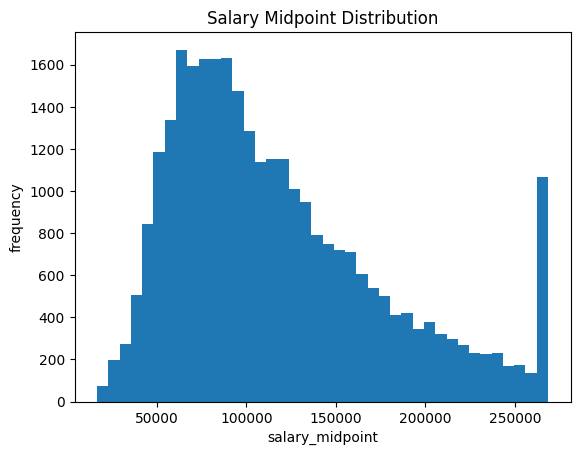

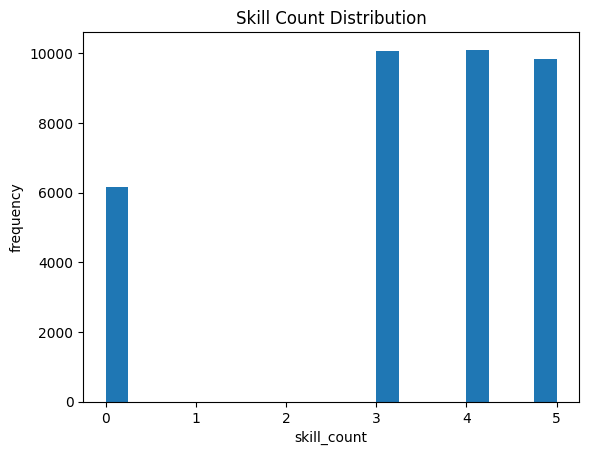

In [9]:

if "salary_midpoint" in master.columns and master["salary_midpoint"].notna().any():
    master["salary_midpoint"].plot(kind="hist", bins=40, title="Salary Midpoint Distribution")
    plt.xlabel("salary_midpoint"); plt.ylabel("frequency")
    plt.show()

if "skill_count" in master.columns and master["skill_count"].notna().any():
    master["skill_count"].plot(kind="hist", bins=20, title="Skill Count Distribution")
    plt.xlabel("skill_count"); plt.ylabel("frequency")
    plt.show()



## 10) Data Quality Report

We compute completeness, duplicate counts, and a date-range validity snapshot (dynamic).


In [10]:
# ============================================================
# Data Quality Report Generator — Safe & Self-Contained
# ============================================================

import pandas as pd
import json
from pathlib import Path

# ------------------------------------------------------------
# 1. Load master if not already in memory
# ------------------------------------------------------------
try:
    master
except NameError:
    # locate cleaned_master.csv inside /data/processed
    PROJECT_ROOT = next(
        (p for p in [Path.cwd()] + list(Path.cwd().parents)
         if (p / "data").exists()),
        Path.cwd()
    )
    processed_file = PROJECT_ROOT / "data" / "processed" / "cleaned_master.csv"
    if processed_file.exists():
        master = pd.read_csv(processed_file, low_memory=False)
        print(f"✅ Loaded master from: {processed_file}")
    else:
        raise FileNotFoundError("cleaned_master.csv not found. Run your cleaning notebook first.")

# ------------------------------------------------------------
# 2. Build Data Quality dictionary
# ------------------------------------------------------------
dq = {
    "rows": int(len(master)),
    "cols": int(master.shape[1]),
    "duplicates": int(master.duplicated().sum()),
    "completeness": {c: round(float(master[c].notna().mean()), 4)
                     for c in master.columns},
    "validity": {}
}

# ------------------------------------------------------------
# 3. Posting-date validity checks
# ------------------------------------------------------------
if "posting_date" in master.columns:
    posting_dates = pd.to_datetime(master["posting_date"], errors="coerce")
    min_date, max_date = posting_dates.min(), posting_dates.max()
    dq["validity"]["posting_date_min"] = (
        str(min_date.date()) if pd.notna(min_date) else None
    )
    dq["validity"]["posting_date_max"] = (
        str(max_date.date()) if pd.notna(max_date) else None
    )

# ------------------------------------------------------------
# 4. Save report under /reports
# ------------------------------------------------------------
PROJECT_ROOT = next(
    (p for p in [Path.cwd()] + list(Path.cwd().parents)
     if (p / "data").exists()),
    Path.cwd()
)
REPORTS = PROJECT_ROOT / "reports"
REPORTS.mkdir(parents=True, exist_ok=True)

dq_path = REPORTS / "data_quality_report.json"
dq_path.write_text(json.dumps(dq, indent=2))

print("✅ Data-Quality Report written →", dq_path.resolve())

# ------------------------------------------------------------
# 5. Quick preview
# ------------------------------------------------------------
print(f"\nRows: {dq['rows']}, Columns: {dq['cols']}, Duplicates: {dq['duplicates']}")
if 'posting_date' in dq.get('validity', {}):
    print(f"Posting date range: {dq['validity']['posting_date_min']} → {dq['validity']['posting_date_max']}")


✅ Data-Quality Report written → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\reports\data_quality_report.json

Rows: 36167, Columns: 36, Duplicates: 0



## 11) Profiling Snapshot (Lightweight)

A compact numeric + categorical summary without heavy dependencies.


In [11]:

profile_num = master.describe(include=[np.number]).T
profile_cat = master.describe(include=['object']).T

profile_num_path = REPORTS / "profiling_numeric_snapshot.csv"
profile_cat_path = REPORTS / "profiling_categorical_snapshot.csv"

profile_num.to_csv(profile_num_path)
profile_cat.to_csv(profile_cat_path)

print("✅ Profiling snapshots written →")
print("  ", profile_num_path)
print("  ", profile_cat_path)


✅ Profiling snapshots written →
   c:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\reports\profiling_numeric_snapshot.csv
   c:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\reports\profiling_categorical_snapshot.csv



## 12) Export Cleaned Master

Exports to `data/processed/cleaned_master.csv` (or `/mnt/data/processed/cleaned_master.csv` in fallback mode).


In [12]:

out_path = PROCESSED / "cleaned_master.csv"
master.to_csv(out_path, index=False)
print("✅ Cleaning complete →", out_path)


✅ Cleaning complete → \mnt\data\processed\cleaned_master.csv



---

### Notes & Assumptions
- If `salary_min/max` are missing, we **proxy** `salary_midpoint` with `salary_usd` (documented above).
- No currency conversion is performed here; add a later step if you have FX rates.
- Skill parsing assumes comma-separated values in `required_skills`. Replace with your tokenizer if needed.
- IQR capping is a **defensive** step to reduce the influence of extreme outliers; tune per role/location group if required.

**Complexities**
- Major steps are linear in the number of rows `n` and columns `c`.  
- Memory usage is roughly `O(n·c)` (typical for in-memory pandas workflows).
